![ACM SIGCHI Summer School on Computational Interaction](imgs/header.png)

# <font face="gotham" color="Brown"> Text based VA_RecSys with BERT </font>




## Table of Contents

1. [Improt Deependencies](#dep)
2. [Load dataset](#loaddata)
3. [Preprocessing](#preproc)
4. [Feature extraction via learning document embeddings](#doc)<br>
5. [Top-K Recommendation](#topn)
6. [Conclusion](#exp)

# <font face="gotham" color="darkred"> The typical RecSys Pipeline  </font>

![The RecSys pipline](imgs/recsys.png)

## 1. Improt Deependencies 

<a id="dep"></a>

In [1]:
import re
import os
import spacy
import sys
import pandas as pd
import torch
import pickle
from PIL import Image
import numpy as np
from string import punctuation
from transformers import BertTokenizer, BertModel
from torchmetrics.functional import pairwise_cosine_similarity
from transformers import logging
import matplotlib.pyplot as plt
from keras.preprocessing import image
from sklearn.feature_extraction.text import CountVectorizer
from transformers import logging
logging.set_verbosity_error()

In [2]:
#!pip install bertopic[flair]
#!pip install -U sentence-transformers

## 2. Load dataset

<a id="loaddata"></a>
The dataset used in this tutorial contains >= 2,300 paintings collections from the National Gallery, London, dating from the mid-13th century to 1900.

![Sample painting](imgs/sample.png)

In [3]:
df = pd.read_csv('resources/datasets/ng-dataset.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.rename(columns={'merged_description': 'enhanced'}, inplace=True)

In [4]:
df.head()

,painting_id,title,artist,date,room,size_format,size_class,description,technique,image,enhanced
0,000-00A8-0000,A Cup of Water and a Rose,Francisco de ZurbarÃÂ¡n,17th_century,006-002N-0000,Landscape,Very Small,<p>Although ZurbarÃÂ¡n frequently included st...,oil painting,https://media.ng-london.org.uk/iiif/009-00YS-0...,<p>Although ZurbarÃÂ¡n frequently included st...
1,000-00S0-0000,Man on a Ladder,Luca Signorelli,16th_century,006-0002-0000,Portrait,Medium,<p>Signorelli is celebrated for his mastery of...,oil painting,https://media.ng-london.org.uk/iiif/009-00UA-0...,<p>Signorelli is celebrated for his mastery of...
2,000-0162-0000,The Boulevard Montmartre at Night,Camille Pissarro,19th_century,006-000L-0000,Landscape,Small,<p>Towards the end of his life Pissarro increa...,oil painting,https://media.ng-london.org.uk/iiif/009-018T-0...,<p>Towards the end of his life Pissarro increa...
3,000-0163-0000,"View of the Westerkerk, Amsterdam",Jan van der Heyden,17th_century,006-000B-0000,Landscape,Medium,<p>This painting is unusually large. It was co...,oil painting,https://media.ng-london.org.uk/iiif/009-01OT-0...,<p>This painting is unusually large. It was co...
4,000-0164-0000,The Museum at Le Havre,Claude Monet,19th_century,006-000T-0000,Landscape,Medium,<p>This is an important work which dates from ...,oil painting,https://media.ng-london.org.uk/iiif/009-01WV-0...,<p>This is an important work which dates from ...


## 3. Preprocessing

<a id="preproc"></a>

"Garbage in, garbage out". 
We need to pre-process the textual descriptions of the paintings so that irrelevant information is removed.

To do that we proceed with the following steps :
- Removing the stopwords (a, the, of, with, ... ) + ( context words : painting, show, ... )
- Removing punctuation
- Removing numbers
- Lemmatization (am, is, are => be )
- Bigram (New York, 19th century, ...)

In [5]:
"""The following method is used to perform text cleaning on a painting description dataset.
    Multiple Natural Language Processing (NLP) techniques are used in order remove
    meaningless information from the dataset."""

path_to_dataset = "resources/datasets/ng-dataset.csv"


def clean_dataframe(df):
    """We apply a transformation to each row of the dataframe using the function replace_break_balise
    Input:
            df: dataframe of paintings
    Output:
            df: dataframe were break lines are removed
    """
    pd.set_option("display.max_colwidth", 1000)
    df["merged_description"] = df["merged_description"].apply(replace_break_balise)
    return df


def replace_break_balise(text):
    """From the index, returns the painting ID from the paintings dataframe
    Input:
            text
    Output:
            text: breaklines + <p> </p> balises,... removed
    """
    text = text.replace("\n", "")
    text = text.replace("<p>", "")
    text = text.replace("</p>", "")
    text = text.replace("<br>", "")
    text = text.replace("<br />", "")
    text = text.replace("< p >", "")
    text = text.replace("</p >", "")
    return text


def dataframe2text(df):
    """We transform the dataframe into a raw text format
    Input:
            df: dataframe of paintings
    Output:
            text
    """
    text = df["merged_description"].to_string(index=False)
    text = re.sub(" +", " ", text).replace("<br>", "")
    text = text.replace("\n ", " \n")
    return text


def add_stopwords(text, nlp):
    my_stop_words = [
        "'s",
        "be",
        "work",
        "painting",
        "early",
        "small",
        "know",
        "appear",
        "depict",
        "tell",
        "type",
        "apparently",
        "paint",
        "show",
        "probably",
        "picture",
        "left",
        "right",
        "date",
        "suggest",
        "hold",
        "de",
        "see",
        "represent",
        "paint",
    ]
    for stopword in my_stop_words:
        nlp.vocab[stopword].is_stop = True
    doc = nlp(text)
    return doc, nlp


def clean_text(text, nlp):
    """Remove stopwords, punctuation and numbers from the text"""
    doc = nlp(text)
    article = ""
    for w in doc:
        # If it's not a space or a stop word or a punctuation mark, add it to our article.
        if (
            not w.is_stop
            and not nlp.vocab[w.lemma_].is_stop
            and not w.is_punct
            and not w.like_num
        ):
            article += w.lemma_ + " "  # Use the lematized version of the word.
    return article


# We wrap all the preprocessing in one function for future usability


def preprocess():
    nlp = spacy.load("en_core_web_sm")
    nlp.max_length = 10000000
    df = pd.read_csv(path_to_dataset)
    df = clean_dataframe(df)
    doc, nlp = add_stopwords(dataframe2text(df), nlp)
    # df = df[['painting_id','merged_description']]
    sentences = []
    painting_ids = []
    for i in range(len(df)):
        idx = df["painting_id"][i]
        cleaned = clean_text(df["merged_description"][i], nlp)
        cleaned = cleaned.replace("   ", " ")
        sentences.append(cleaned)
        painting_ids.append(idx)

    # Dump both lists into a dictionary within a .pickle file.
    PREPROCESSED_FILE = "resources/datasets/preprocessed/painting_descriptions.pickle"
    file = open(PREPROCESSED_FILE, "wb")
    pickle_rick = {"painting_ids": painting_ids, "painting_descriptions:": sentences}
    pickle.dump(pickle_rick, file)
    file.close()
    print("Preprocessing done!")
#Apply preproecessing
preprocess()

Preprocessing done!


In [1]:
#!python -m pip install -U pydantic spacy==3.1.0
#!python -m spacy validate
#!python -m spacy download en_core_web_sm

## 4. Feature extraction via learning document embeddings

<a id="doc"></a>

![data](imgs/data.png)
![Learning Document embeddings](imgs/embedding.png)

In [7]:
"""
Define a method to obtain the vocab IDs of the tokenized sentence and the segment IDs vector of the sentence.
"""


def tokenize_and_segment(sentence, preprocess=False):
    # Load pre-trained model tokenizer (vocabulary)
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    if preprocess:
        sentence = "".join([c for c in sentence if c not in punctuation]).lower()
    marked_text = "[CLS] " + sentence + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)  # A vector of 1s.
    return indexed_tokens, segments_ids


"""
Method to apply the BERT model on one sentence composed of indexes of tokens and segments.
"""


def get_hidden_states(bert_model, idx_tokens, idx_segments):
    tokens_tensor = torch.tensor([idx_tokens])
    segments_tensor = torch.tensor([idx_segments])
    with torch.no_grad():
        outputs = bert_model(tokens_tensor, segments_tensor)
    hidden_states = torch.stack(outputs.hidden_states, dim=0)
    return hidden_states  # Output shape: [layers, batches, seq_len, features]


""" 
Average the last N layers (last_layers) of each token producing a single N-length vector.
"""


def create_sentence_embeddings(hidden_states, layer_idx=-2):
    """
    Parameters
        hidden_states: output from the BERT model.
        layer_idx: the layer to be used for obtaining the features (default=second to last layer).
    """

    # Remove the batch dim, since we work with individual sentences.
    token_embeddings = torch.squeeze(
        hidden_states, dim=1
    )  # Output shape: [layers, seq_len, features]

    # Swap dimensions 0 and 1.
    token_embeddings = token_embeddings.permute(
        1, 0, 2
    )  # Output shape: [seq_len, layers, features]

    # Obtain average of features from all tokens.
    sentence_embeddings = torch.mean(hidden_states[layer_idx][0], dim=0)

    # Return embeddings.
    return sentence_embeddings


""" 
Use the create_sentence_embeddings function as feature extractor
 """


def bert_feature_extractor(
    sentences, bert_model, preprocess=False, as_numpy=False, layer_idx=-2
):
    """
    Parameters
        sentences: list of sentences.
        bert_model: pre-trained BERT model.
        as_numpy: return tensors as numpy or not. If False, then dataset[i] is a torch tensor.
    Output
        dataset: a list with N tensors (torch or numpy) with features, with N=len(sentences).
    """

    # Our dataset.
    dataset = []

    # Put the model in "evaluation" mode.
    bert_model.eval()

    # Go through the sentences and get the features of each.
    for sentence in sentences:
        idx_tokens, idx_segments = tokenize_and_segment(sentence, preprocess)
        hidden_bert = get_hidden_states(bert_model, idx_tokens, idx_segments)
        feature_vector = create_sentence_embeddings(hidden_bert, layer_idx)
        dataset.append(feature_vector.numpy() if as_numpy else feature_vector)

    # Return features list.
    return dataset


def extract_features():
    # Load pre-trained model (weights)
    bert_model = BertModel.from_pretrained(
        "bert-base-uncased", output_hidden_states=True
    )

    # Put the model in "evaluation" mode, meaning feed-forward operation.
    bert_model.eval()

    # Read the dataset
    DATASET_FILE = "resources/datasets/preprocessed/painting_descriptions.pickle"
    dataset_path = DATASET_FILE
    dataset = pickle.load(open(dataset_path, "rb"))
    print(dataset.keys())

    painting_ids = dataset["painting_ids"]
    sentences = dataset["painting_descriptions:"]

    """
    Extract the BERT features and
    Forward the train set to BERT to obtain the feature vectors for each sentence.
    """
    dataset = bert_feature_extractor(
        sentences=sentences, bert_model=bert_model, preprocess=True, as_numpy=True
    )
    dataset = np.asarray(dataset)
    print("Dataset shape:", dataset.shape)

    """
    Generate a new pickle file with the BERT features and the painting indeces.
    """
    DATASET_BERT_FILE = "Models/paintings_bert_features.pickle"

    # Dump both lists into a dictionary within a .pickle file.
    file = open(DATASET_BERT_FILE, "wb")
    pickle_rick = {"painting_ids": painting_ids, "bert_features": dataset}
    pickle.dump(pickle_rick, file)
    file.close()
    print("BERT feature extraction done!")
extract_features()

## 5. Top-K Recommendation
<a id="topn"></a>

In [8]:
class BertEngine():

    def __init__(self):
        self.painting_df = pd.read_csv("resources/datasets/ng-dataset.csv")
        # self.painting_ids = None
        # self.bert_features = None
        self.load_data()


    def unpack_prefs(self, preferences):
        painting_list = []
        weights = []
        for painting, rating in preferences.items():
            painting_list.append(painting)
            weights.append(rating)
        xmin = min(weights)
        xmax = max(weights)
        for i, x in enumerate(weights):
            weights[i] = (x - xmin) / (xmax - xmin + sys.float_info.epsilon)

        return painting_list, weights
    
    def index2pid(self, painting_df, index):
        """From the index, returns the painting ID from the paintings dataframe
        Input:
                painting_df: dataframe of paintings
                index: index of the painting in the dataframe
        Output:
                pid: return the painting ID (e.g: 000-02T4-0000 )
        """
        try:
            pid = painting_df.iloc[index].painting_id
        except IndexError as ie:
            pid = "Index '" + index + "' not found in dataset."
        return pid

    def indexlist2pidlist(self, painting_df, index_list):
        """From a list of indexes, returns the painting IDs
        Input:
                painting_df: dataframe of paintings
                index_list: list of the painting indexes in the dataframe
        Output:
                pid: list of paintings ID
        """
        pids_list = [self.index2pid(painting_df, index) for index in index_list]
        return pids_list

    def pid2index(self, painting_df, painting_id):
        """From the painting ID, returns the index of the painting in the painting dataframe
        Input:
                painting_df: dataframe of paintings
                painting_list: list of paintings ID (e.g ['000-02T4-0000', '000-03WC-0000...'])
        Output:
                index_list: list of the paintings indexes in the dataframe (e.g [32, 45, ...])
        """
        try:
            index = painting_df.loc[painting_df["painting_id"] == painting_id].index[0]
        except IndexError as ie:
            index = "Painting ID '" + painting_id + "' not found in dataset."
        return index

    def pidlist2indexlist(self, painting_df, painting_list):
        """From a list of painting ID, returns the indexes of the paintings
        Input:
                painting_df: dataframe of paintings
                painting_list: list of paintings ID (e.g ['000-02T4-0000', '000-03WC-0000...'])
        Output:
                index_list: list of the paintings indexes in the dataframe (e.g [32, 45, ...])
        """
        index_list = [
            self.pid2index(painting_df, painting_id) for painting_id in painting_list
        ]
        return index_list
    
    def load_data(self):
        # Load dataset.
        dataset = pickle.load(
            open("Models/paintings_bert_features.pickle", "rb")
        )

        # Pre-process dataset to remove missing paintings.
        painting_ids = []
        bert_features = []
        image_files_names = os.listdir("resources/datasets/ng_images/")
        painting_ids_dict = dict.fromkeys(dataset["painting_ids"], "YES")

        for i in range(0, len(image_files_names)):
            painting_name = re.sub(".jpg", "", image_files_names[i])
            if painting_name in painting_ids_dict.keys():
                painting_ids.append(painting_name)
                idx_of_painting = dataset["painting_ids"].index(painting_name)
                bert_features.append(dataset["bert_features"][idx_of_painting])

        self.painting_ids = painting_ids
        self.bert_features = bert_features


    def get_distances(self, selected_image_names):
        """
        Input:
            -> selected_image_names: list with strings of names of the images to analyse.
        Output:
            -> distances: numpy with cosine distance between each image in selected_image_names and bert_features.
        """
        selected = []
        top_sim_images = []

        # Get the features of the selected images using the painting_ids list.
        for i in range(len(selected_image_names)):
            feat_idx = self.painting_ids.index(selected_image_names[i])
            selected.append(self.bert_features[feat_idx])
        selected = np.asarray(selected)
        bert_features = np.asarray(self.bert_features)

        # Calculate cosine distance with torch.
        selected = torch.from_numpy(selected)
        bert_features = torch.from_numpy(bert_features)
        cosine_distances = pairwise_cosine_similarity(selected, bert_features)
        cosine_distances = cosine_distances.numpy()
        return cosine_distances


    def get_top_similars(self, distances, n):
        """
        Input:
            -> distances: numpy of distances from some paintings to the rest of the original dataset.
            -> painting_ids: list of names of the images.
            -> n: number of top-N most similar images to consider.
        Output:
            -> top_sim_images: list with the names of the top-N most similar images.
        """
        top_sim_images = []
        for i in range(distances.shape[0]):
            top_distances = np.argsort(distances[i, :]).reshape(-1)[:n]
            nearest_ids = [self.painting_ids[idx] for idx in top_distances]
            top_sim_images.append(nearest_ids)
        return top_sim_images, top_distances


    def get_weighted_distances(self, distances, weights):
        """
        Input:
            -> distances: numpy of distances from some paintings to the rest of the original dataset.
            -> wights: a list of weights given to each painting.
        Output:
            -> weighted_distances: numpy with weighted avg distances of shape (1, distances.shape[1]).
            -> confidences: numpy with the inverse of weighted_distances an the same shape.
        """
        assert (
            len(weights) == distances.shape[0]
        )  # Assert if num weights == num images used to calculate distance.
        weights = np.asarray(weights).reshape(-1, 1)
        N = distances.shape[0]
        weighted_distances = np.sum(np.multiply(weights, distances), axis=0) / N
        weighted_distances = np.reshape(weighted_distances, (1, -1))
        confidences = 1 - weighted_distances
        return weighted_distances, confidences


    def retrieval(self, preferences, n=3):
        """Recommand paintings for a user based on a list of items that were liked
        Input:
                painting_list: list of paintings index liked by a user
                weights: user ratings
                n: number of recommendation wanted
        Output:
                a list of indexes for recommended paintings
        """
        painting_list, weights = self.unpack_prefs(preferences)

        # Apply function and get distances and top-N most similar images.
        distances = self.get_distances(painting_list)

        # Apply the weighting mechanism.
        weighted_distances, weighted_confidences = self.get_weighted_distances(
            distances, weights
        )
        top_n_pids, top_distances = self.get_top_similars(
            weighted_distances, n
        )
        top_n_pids = [item for sublist in top_n_pids for item in sublist]
        # weighted_confidences = weighted_confidences.reshape(-1)
        # scores = np.sort(weighted_confidences[:n])[::-1]
        return list(top_n_pids)

In [9]:
dir_path='resources/datasets/ng_images/'
def print_image(dir_path, selected_images_keys_list):
    fig = plt.figure()
    for i in range(len(selected_images_keys_list)):
        img_path = dir_path + selected_images_keys_list[i] + '.jpg'
        img = image.load_img(img_path, target_size=(224, 224))
        a = fig.add_subplot(1, len(selected_images_keys_list), i+1, autoscale_on=True)
        imgplot = plt.imshow(img)
        a.set_title(selected_images_keys_list[i])
        plt.axis('off')
        
def print_images(dir_path, selected_images_keys_list):
    fig, axes = plt.subplots(1, len(selected_images_keys_list), figsize=(15, 5))
    
    for i, image_key in enumerate(selected_images_keys_list):
        img_path = os.path.join(dir_path, f"{image_key}.jpg")
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(image_key)
        axes[i].axis('off')
    
    plt.tight_layout()
    #display(fig)

### Simulate User preferences

In [10]:
preferences = {
        "000-02Q1-0000": 2,
        "000-04H4-0000": 5,
        "000-02W4-0000": 5,
        "000-02ND-0000": 3,
        "000-03N1-0000": 5,
        "000-019R-0000": 5,
        "000-03TQ-0000": 5,
        "000-019X-0000": 1,
        "000-02OU-0000": 5,
    }

### Retrieve top-K  Recommendations 

In [11]:
eng = BertEngine()
Recommendations = eng.retrieval(preferences, n=9)

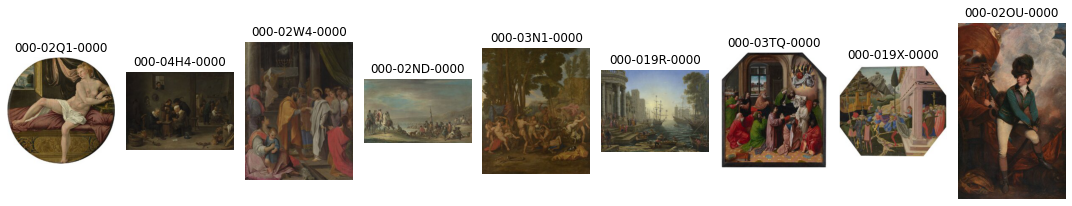

In [12]:
#plot user preferences
print_images(dir_path, preferences.keys())

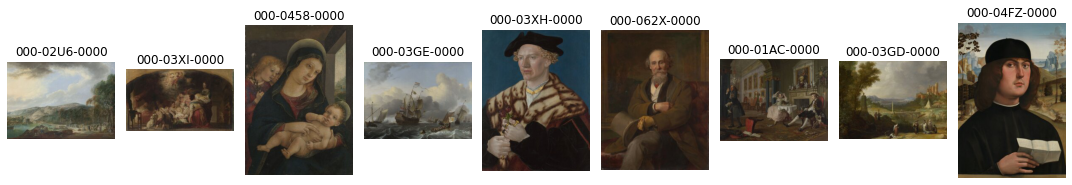

In [13]:
#plot Recommendations
print_images(dir_path, Recommendations)

## 🏁 6. Conclusion

<a id="con"></a>

Now, you know:

1. How to extract textual features by learning document embeddings using pre-trained Language Models such as BERT
2. How to leverage the extracted features for a Recommendation task

The resourses used in this tutorial are partially taken from our [CHI2023 paper: The Elements of Visual Art Recommendation: Learning Latent Semantic Representations of Paintings](https://dl.acm.org/doi/abs/10.1145/3544548.3581477)

![VA_RecSys](imgs/VA_RecSys.png)



